In [76]:
import requests, json, time, re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [10]:
reddit = pd.read_csv('./datasets/reddit.csv')

In [11]:
reddit.head()

,text,is_eli5
0,"ELI5: Apparently, the smell of freshly mowed g...",1
1,ELI5:How after 5000 years of humanity survivin...,1
2,ELI5: Why can people walk many miles without d...,1
3,ELI5: Military officers swear to protect and d...,1
4,ELI5: How come you can be falling asleep watch...,1


In [38]:
reddit['text'] = reddit.text.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x))
reddit['text'] = reddit.text.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))
reddit['text'] = reddit.text.map(lambda x: re.sub('(ELI5:|eli5)[s]?', ' ', x, flags=re.I))

In [39]:
reddit.head()

,text,is_eli5
0,"Apparently, the smell of freshly mowed grass...",1
1,How after 5000 years of humanity surviving of...,1
2,Why can people walk many miles without disco...,1
3,Military officers swear to protect and defen...,1
4,How come you can be falling asleep watching ...,1


In [40]:
X = reddit.drop('is_eli5', axis=1)
y = reddit['is_eli5']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=24)

In [42]:
tfidf = TfidfVectorizer(stop_words='english', max_df=.95, min_df=5)

In [43]:
train_raw = tfidf.fit_transform(X_train['text'])

In [44]:
train_raw

<2756x1922 sparse matrix of type '<class 'numpy.float64'>'
	with 32150 stored elements in Compressed Sparse Row format>

In [45]:
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())

train_df.head(10)

,000,10,100,11,12,13,14,15,16,17,...,yeah,year,years,yellow,yes,yesterday,york,young,youtube,zero
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
train_df.fillna(0, inplace=True)

In [47]:
train_df.isnull().sum().sum()

0

In [48]:
test_raw = tfidf.transform(X_test['text'])
test_df = pd.SparseDataFrame(test_raw, columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)
test_df.head()

,000,10,100,11,12,13,14,15,16,17,...,yeah,year,years,yellow,yes,yesterday,york,young,youtube,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
params = {"min_samples_split": [12, 25, 40]}

In [50]:
rf = RandomForestClassifier(n_estimators=100)

In [51]:
gs = GridSearchCV(rf, param_grid=params, return_train_score=True, cv=5)

In [52]:
gs.fit(train_df, y_train)
gs.score(train_df, y_train)

0.9825834542815675

In [53]:
gs.score(test_df, y_test)

0.6683587140439933

In [54]:
gs.best_params_

{'min_samples_split': 25}

In [55]:
gs.best_estimator_.feature_importances_

array([6.57560294e-04, 8.01217477e-04, 2.47347767e-04, ...,
       3.09564294e-04, 1.54571692e-03, 5.21369936e-05])

In [56]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, train_df.columns, columns=['importance'])

In [57]:
feat_importance.sort_values(by='importance', ascending=False).head(20)

,importance
does,0.014973
just,0.012015
people,0.011979
want,0.011677
work,0.009260
think,0.009135
say,0.009017
causes,0.007377
reddit,0.007020
dog,0.006870


In [58]:
feat_importance.sort_values(by='importance', ascending=False).tail(20)

,importance
complex,0.0
minimum,0.0
comparison,0.0
suggested,0.0
plus,0.0
browsing,0.0
thinks,0.0
purely,0.0
passed,0.0
anybody,0.0


Text(0, 0.5, 'Feature')

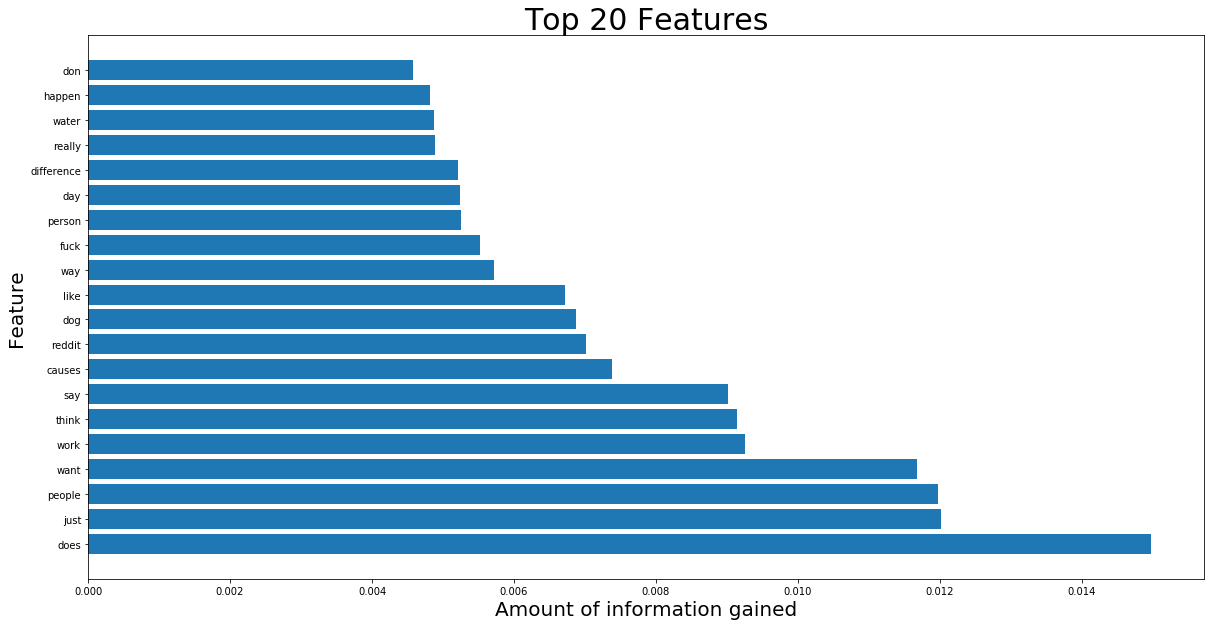

In [59]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)

In [71]:
svc = SVC(gamma='scale')

In [72]:
svc.fit(train_df, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [73]:
svc.score(train_df, y_train)

0.9753265602322206

In [74]:
svc.score(test_df, y_test)

0.6835871404399323

In [77]:
mnb = MultinomialNB()

In [78]:
mnb.fit(train_df, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [79]:
mnb.score(train_df, y_train)

0.8370827285921626

In [80]:
mnb.score(test_df, y_test)

0.700507614213198